In [63]:
! git clone https://github.com/kaspergroenbek98/first-first-year-project.git
### All import calls.
import numpy as np
import nltk
import csv
import re
from collections import Counter
import pandas as pd
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
nltk.download('stopwords')

fatal: destination path 'first-first-year-project' already exists and is not an empty directory.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
### Functions

### START OF VOCABULARY ###
def generate_vocabulary(data, featureData, vocabType): #featureData = data.gender
    '''
    Returns a list/vocabulary of len <= "size" based on the vocabType and the featureColumn specified
    '''
    size = 2000
    # Only get large groups to get representative data
    major_features = nltk.FreqDist(featureData).most_common(5)
    major_masks = [featureData == f for (f, cnt) in major_features]
    fqs = [nltk.FreqDist(word for line in data.text[mask] for word in line.split()) for mask in major_masks]
    return list(vocabType(data, featureData, major_features, major_masks, fqs, size))

def vocab_most_common(data, featureData, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises the most common words for each feature
    '''
    vocabulary = set()
    # get the most common words in each freq dist. zip(*...) removes the counts from fd, and updates vocabulary ONLY with the words
    for fd in fqs:
        vocabulary.update(list(zip(*fd.most_common(size//len(major_features))))[0])
    return vocabulary

def vocab_unique(data, fCol, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises words which are uncommon in other features, but common in one feature
    '''
    major_mask = np.array(major_masks.sum(axis=0), dtype='bool')
    fq = tweet_word_distribution(data[major_mask,6]) # Get a fq over the words used by all in the major categories
    words = [word for (word, cnt) in fq.items() if cnt >= 20] # removes rarely mentioned words which probably arent indicative of a significant trend
    priorityArray = []
    for i, word in enumerate(words):
        priorityArray.append([word])
        #divide frequency of word in that state by the tweetcount from that state, and by how often that word is used in total by all states
        score = max(fqs[fID][word]/(int(major_features[fID][1])*fq[word]) for fID in range(len(major_masks)))
        priorityArray[i].append(score)
    priorityArray.sort(key = lambda x: x[1], reverse=True) # Sort them based on their best score
    vocabulary = list(zip(*priorityArray[:size]))[0] # Removes their scores
    return vocabulary




### END OF VOCABULARY ###
    

# def identify_hashtags(data):
#     col = np.zeros((data.shape[0],1), 'str')
#     data = np.append(data, col, axis=1)
#     for i, text in enumerate(data[:,6]):
#         results = re.findall(r"#\w+", text) # Finds matches and returns them as an iterable
#         if results:
#             data[i,15] = ' '.join(results)
#         else:
#             data[i,15] = ''


def divide_featureset(feature):
    '''
    Divides numpy featureset of (featureVector, classification) into a 80:10:10 train:dev:test set
    '''
    testSize = int(len(feature)*0.8)
    train, rest = feature[:testSize], feature[testSize:]
    restSize = len(rest)//2
    dev, test = rest[:restSize], rest[restSize:]
    return train, dev, test


#RegEx cleaner for SKlearn (Maybe merge with Clean()).
def cleaner(text):
    stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)
    text = text.lower() #All lowercase
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub('https?://[A-Za-z0-9./]+','', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('b4', 'before', text)
    text = text.strip(' ')
    text = ''.join(char for char in text if char.isalpha() or char == ' ')
    text = ''.join(stemmer.stem(text)) #Stem the words using SnowballStemmer
    return text

def delete_rows(dataset, column, ID):
  """
  Takes a panda dataframe as first arg. The df column as second arg and the ID 
  as third. Returns a mask shoving only those values in the dataset.
  """
  mask = dataset[dataset[str(column)] == str(ID)]
  return mask

"""
Needs revisiting (below)
"""
# def clean(tweet):
#     stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)

#     # Remove all stopwords, non-alphabet words (except spaces), and stem the words
#     for text in tweet:
#     text = text.lower()
#     text = ''.join(char for char in tweet if char.isalpha() or char == ' ')
#     text = ' '.join(stemmer.stem(text))


"""
Needs a concrete decision on future use of the code below
"""
# def generate_features(data, vocabulary, fCol):
#     """ 
#     Creates tuples with a vector containing boolean values depending on whether
#     or not the word is in the tweet - along with the label of the tweet.
#     """
#     features = [(tweet_features(d.split(), vocabulary), c) for (d,c) in zip(data[:,6], data[:,fCol])] # column 6 is text data, column 2 is gender data
#     return features

'\nNeeds a concrete decision on future use of the code below\n'

In [71]:
# Using pandas to load the data file into a CSV.
# ISO-8859-1 is the encoding for tweets.
df = pd.read_csv("first-first-year-project/data.csv", encoding = "ISO-8859-1")
#First step to cleaning the data, removing the categories we dont need.
data = df.drop(["other_topic","resolution_topics", "tweet_coord", "tweet_created","tweet_id", "name", "retweet_count", "tweet_date", "user_timezone"], axis = 1)
#Cleaning all the text in our data with our newly build cleaner() function.
for i in range(len(data.text)):
  data.text[i] = cleaner(data.text[i])

data.text[1]

'newyearsresolution finally master part of kitchen sink'

In [81]:
# Vectorize using sklearn based on a vocabulary
featureData = data.Resolution_Category
vectorizer = CountVectorizer(analyzer="word", stop_words= "english", min_df = 20, binary= True, vocabulary = generate_vocabulary(data, featureData, vocab_most_common))

#Here we use term frequency to downscale the importance of words occuring many times in a tweet. That way we hopefully get more weighted words. 
tfidf_transformer = TfidfTransformer()
features = vectorizer.fit_transform(data.text)
tfidf_features = tfidf_transformer.fit_transform(features)

from sklearn.model_selection import KFold
# Store an object of the KFold class in a variable with shuffle=True
k= 10
kf = KFold(n_splits=k, shuffle=True)
showReport = False

# """ 
# Loop for the models and their designated folds (1 to k)
# and calculate the average of each of the 'k' models' accuracy
# using the NB classifier and k-fold model class.
# """
count = 0 # sum to calculate average of model accuracies
for i, (train, test) in enumerate(kf.split(features)): # Loop over K chunk of data splits
    #Accuracy using term frequency. (Odd that its lower, but we do have a small data set)
    NBmodel = MultinomialNB().fit(tfidf_features[train], featureData[train])
    predicted = NBmodel.predict(tfidf_features[test])
    accuracy = np.mean(predicted == featureData[test])
    count += accuracy

    #A classification_report
    print("Iteration no.", i, "\n")
    print("Accuracy of iteration number", i, ":", accuracy)
    if showReport: print(metrics.classification_report(data.gender[test], predicted))
    print("\n\n")

average = count/k
print("The accuracy average of the K-fold models:", average)

Iteration no. 0 

Accuracy of iteration number 0 : 0.49800796812749004



Iteration no. 1 

Accuracy of iteration number 1 : 0.47105788423153694



Iteration no. 2 

Accuracy of iteration number 2 : 0.4750499001996008



Iteration no. 3 

Accuracy of iteration number 3 : 0.49700598802395207



Iteration no. 4 

Accuracy of iteration number 4 : 0.5129740518962076



Iteration no. 5 

Accuracy of iteration number 5 : 0.48303393213572854



Iteration no. 6 

Accuracy of iteration number 6 : 0.48502994011976047



Iteration no. 7 

Accuracy of iteration number 7 : 0.49500998003992014



Iteration no. 8 

Accuracy of iteration number 8 : 0.47904191616766467



Iteration no. 9 

Accuracy of iteration number 9 : 0.5189620758483033



The accuracy average of the K-fold models: 0.4915173636790165


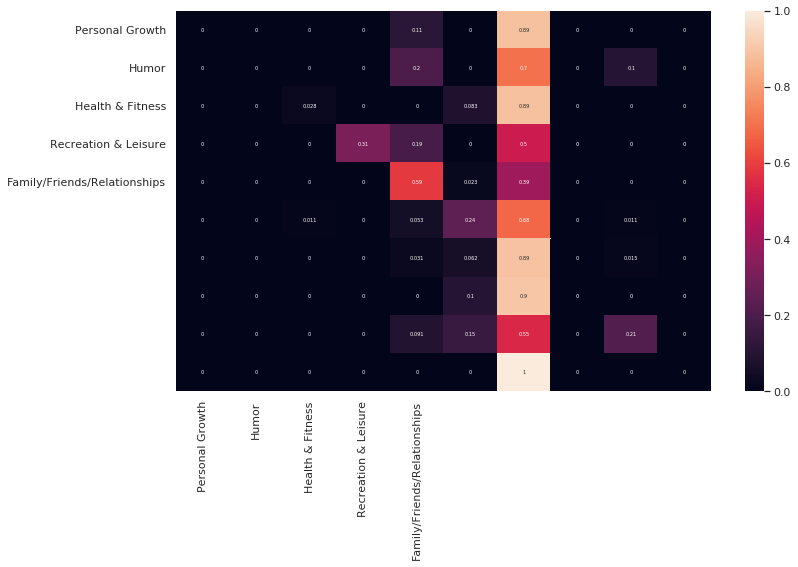

In [83]:
# A nice confusion matrix using seaborn.
array = metrics.confusion_matrix(featureData[test], predicted, normalize='true')
plt.figure(figsize=(12,7))
sn.set(font_scale=1) # for x/y label size
categories = list(zip(*nltk.FreqDist(featureData).most_common(5)))[0]
sn.heatmap(array, annot=True, annot_kws={"size": len(categories)}, xticklabels = categories, yticklabels = categories) # annot_kws is the size of the numbers.
plt.show()

In [86]:
featureData[test] == ['Personal Growth', 'Humor']

ValueError: ignored